# Part 1: Segmentation of hands

In this part, you are given a sequence of video frames in which a person is playing the piano with both hands. Try to develop an algorithm to identify the pianist's hands. Portions of the hands are sometimes in deep shadow, which creates a challenging imaging situation.

In [372]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from os import listdir, makedirs
from os.path import isfile, join, abspath, exists

In [373]:
# read data
data_path = abspath('./CS585-PianoImages')
data_list = [join(data_path, file) for file in listdir(data_path) if isfile(join(data_path, file)) and 'png' in file]

In [374]:
data_list

['C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\CS585-PianoImages\\piano_14.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\CS585-PianoImages\\piano_15.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\CS585-PianoImages\\piano_16.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\CS585-PianoImages\\piano_17.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\CS585-PianoImages\\piano_18.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\CS585-PianoImages\\piano_19.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\CS585-PianoImages\\piano_22.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\CS585-PianoImages\\piano_23.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\CS585-PianoImages\\piano_24.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\CS585-PianoImages\\piano_25.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\CS585-PianoImages\\piano_26.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\CS585-PianoImages\\piano_27.png',
 'C:\\Users\\ljsPC\\Desktop\\CS585\\HW4\\CS585-PianoImages\\piano_33.png',
 'C:\\Users\\ljsPC\\Deskt

In [375]:
data_frames = []

for file in data_list:
    img = cv2.imread(file)
    data_frames.append(img.copy())
    
    img_grayscale = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
data_frames = np.array(data_frames)

## compute the average value of all image frames

In [376]:
avg_img = np.sum(data_frames, axis=0)


avg_img = avg_img / data_frames.shape[0]
avg_img = avg_img.astype(np.uint8)

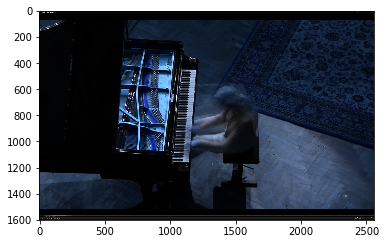

In [377]:
plt.imshow(avg_img)
plt.show()

## Difference the frames

In [378]:
motions = []

for frame in data_frames:
    diff = cv2.absdiff(frame, avg_img)
    diff_grayscale = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    
    boolean_filter = diff_grayscale > 5
    motion = np.zeros_like(frame)
    motion[boolean_filter] = frame[boolean_filter]
    motions.append(motion)
    
motions = np.array(motions)

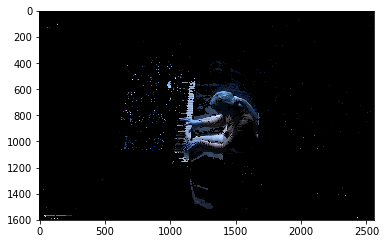

In [379]:
plt.imshow(motions[0])
plt.show()

## Skin Color Detection

In [380]:
# returns the @param img with only skin color (the rest of the pixels are black)
def skinDetect(img):
    B = img[:, :, 0]
    G = img[:, :, 1]
    R = img[:, :, 2]
    skin = np.zeros_like(img)
    maxMat = imgMax(img)
    minMat = imgMin(img)
    # 
    cond = (R > 100) & (B > 50) & (B < 130) & (G > 70) & ((maxMat - minMat) > 50) & (np.abs(R - G) > 40) & (R > G) & (R > B)
    skin[cond] = img[cond]
    return skin

def imgMax(img):
    maxMat = np.max(img.reshape(img.shape[0]*img.shape[1], 3), axis=1).reshape(img.shape[0], img.shape[1])
    return maxMat

def imgMin(img):
    minMat = np.min(img.reshape(img.shape[0]*img.shape[1], 3), axis=1).reshape(img.shape[0], img.shape[1])
    return minMat

In [381]:
skin_imgs = []
for img in motions:
    skin_imgs.append(skinDetect(img))

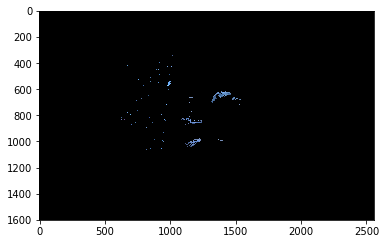

In [382]:
plt.imshow(skin_imgs[0])
plt.show()

## Find Hand Positions

In [383]:
# return the bounding boxes of the largest three blobs
def three_largest_blobs(grayscale_img):
    _, contours_opencv, hierarchy = cv2.findContours(grayscale_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # choose the largest size object
    largest_three_area = [0,0,0]
    largest_three_index = [0,0,0]
    for index in range(len(contours_opencv)):
        area = cv2.contourArea(contours_opencv[index])
        if area > np.min(largest_three_area):
            largest_three_index[np.argmin(largest_three_area)] = index
            largest_three_area[np.argmin(largest_three_area)] = area 

    bounding_boxes = []
    for index in largest_three_index:
        x, y, w, h = cv2.boundingRect(contours_opencv[index])
        bounding_boxes.append([x, y, w, h])
    
    return bounding_boxes, largest_three_area

In [384]:
bounding_boxes = []
largest_three_areas = []
for skin_img in skin_imgs:
    img_skin_grayscale = cv2.cvtColor(skin_img, cv2.COLOR_BGR2GRAY)
    
    largest_three__boxes, largest_three_area = three_largest_blobs(img_skin_grayscale)
    bounding_boxes.append(largest_three__boxes)
    largest_three_areas.append(largest_three_area)

bounding_boxes = np.array(bounding_boxes)
largest_three_areas = np.array(largest_three_areas)
print(bounding_boxes, largest_three_areas)

[[[1118  840  129   35]
  [1316  624  153   86]
  [1110  982  127   65]]

 [[1120  880  113   39]
  [1342  579  142   86]
  [1110 1000  122   34]]

 [[1134  985   93   48]
  [1120  856  104   43]
  [1363  577  121   76]]

 [[1109  825  131   52]
  [1350  579  147   78]
  [1109  996  127   50]]

 [[1137  988   99   53]
  [1316  590  163   95]
  [1115  871  114   40]]

 [[1134  991   98   48]
  [1108  870  118   40]
  [1316  588  163   95]]

 [[1118  990  119   52]
  [1350  581  128   76]
  [1102  826  134   42]]

 [[1346  583  139   78]
  [1105  872  129   43]
  [1110 1012  136   42]]

 [[1117  874  114   40]
  [1374  570  135   79]
  [1114 1001  123   34]]

 [[1099  879  139   45]
  [1384  559  135   77]
  [1111  998  125   35]]

 [[1372  553  138   77]
  [1145  983   94   53]
  [1107  845  128   45]]

 [[1108  990  121   40]
  [1361  562  136   87]
  [1064  866  162   47]]

 [[1281  442  132   69]
  [1199  650   44   14]
  [1123  639  124   78]]

 [[1150  548  112   43]
  [1294  389  

In [385]:
# draw bounding box for each image
for img_index in range(data_frames.shape[0]):
    for bounding_box_index in range(bounding_boxes[img_index].shape[0]):
        # two hands and the head are detected
        if np.min(largest_three_areas[img_index]) > 1000:
            x, y, w, h = bounding_boxes[img_index][bounding_box_index]
            # exclude head blob
            if x != np.max(bounding_boxes[img_index][:,0]):
                # left hand at the bottom
                if y == np.max(bounding_boxes[img_index][:,1]):
                    cv2.rectangle(data_frames[img_index], (x, y), (x + w, y + h), (0, 255, 0), 5, 8, 0)
                    cv2.putText(data_frames[img_index], 'left hand', (x, y),cv2.FONT_HERSHEY_PLAIN,2,(255,0,0), 2)
                # right hand
                else:
                    cv2.rectangle(data_frames[img_index], (x, y), (x + w, y + h), (0, 0, 255), 5, 8, 0)
                    cv2.putText(data_frames[img_index], 'right hand', (x, y),cv2.FONT_HERSHEY_PLAIN,2,(255,0,0), 2)
        # two hands are overlapped
        else:
            x, y, w, h = bounding_boxes[img_index][bounding_box_index]
            # exclude head blob and the overlapped hand
            if x != np.max(bounding_boxes[img_index][:,0]) and largest_three_areas[img_index][bounding_box_index] > 1000:
                cv2.rectangle(data_frames[img_index], (x, y), (x + w, y + h), (0, 255, 0), 5, 8, 0)
                cv2.putText(data_frames[img_index], 'overlapped hand', (x, y),cv2.FONT_HERSHEY_PLAIN,2,(255,0,0), 2)

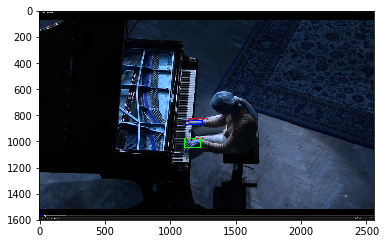

In [386]:
plt.imshow(data_frames[0])
plt.show()

## Save the output images

In [387]:
# write the image to the output file
if not exists('./output'):
    makedirs('./output')

count = 1
for output in data_frames:
    cv2.imwrite('./output/'+str(count)+'.jpeg',output)
    count += 1